In [14]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from copy import deepcopy
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import re
import pandas as pd
import seaborn as sns
from math import ceil
from sklearn.linear_model import LinearRegression

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)
from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs, sf_inputs_discrete

device = 'cpu'

In [15]:
def get_gradients(
    xs, ys, zs, interpolate=True,
    smooth=False
    ):
    
    x_list = np.sort(np.unique(xs))
    y_list = np.sort(np.unique(ys))
    dx = x_list[1:] - x_list[:-1]
    dy = y_list[1:] - y_list[:-1]
    x, y = np.meshgrid(x_list, y_list)
    z = np.zeros(x.shape)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            idx = np.logical_and(
                xs==x[i,j], ys==y[i,j]
                )
            z[i,j] = np.nanmean(zs[idx])
            
    if interpolate:
        nan_mask = np.isnan(z)
        if np.sum(nan_mask) > 0:
            nonnan_mask = np.logical_not(nan_mask)
            nan_indices = np.argwhere(nan_mask)
            data_X = np.vstack(
                [x[nonnan_mask].flatten(),
                 y[nonnan_mask].flatten()]).T
            data_y = z[nonnan_mask].flatten()
            reg = LinearRegression().fit(data_X, data_y)

            interp_vals = reg.predict(
                np.vstack(
                [x[nan_mask].flatten(),
                 y[nan_mask].flatten()]).T
                )
            z[nan_mask] = interp_vals
        
    if smooth:
        from scipy.ndimage.filters import gaussian_filter
        z = gaussian_filter(z, 1.)
        
    return z

In [16]:
model_gammas = [0.6, 0.75, 0.8, 0.85]
model = 'rnn'

In [27]:
gains = []
gammas = []
for idx, gamma in enumerate(model_gammas):
    with open(f'/home/chingf/engram/Ching/03_td_discrete_corr/5a_{model}_results_gamma{gamma}.p', 'rb') as f:
        results = pickle.load(f)
        fieldsizes = np.array(results['fieldsizes'])
        init_sparsities = np.array(results['init_sparsities'])
        sigmas = np.array(results['sigmas'])
        sizemat = get_gradients(init_sparsities, sigmas, fieldsizes)
    if idx == 0:
        base_size = sizemat
        gains.append(1)
        gammas.append(gamma)
    else:
        per_dset_gain = sizemat/base_size
        per_dset_gain = per_dset_gain.flatten().tolist()
        gains.extend(per_dset_gain)
        gammas.extend([gamma]*len(per_dset_gain))

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


In [31]:
gains = []
gammas = []
for idx, gamma in enumerate(model_gammas):
    with open(f'/home/chingf/engram/Ching/03_td_discrete_corr/5a_{model}_results_gamma{gamma}.p', 'rb') as f:
        results = pickle.load(f)
        fieldsizes = np.array(results['fieldsizes'])
        init_sparsities = np.array(results['init_sparsities'])
        sigmas = np.array(results['sigmas'])
        sizemat = get_gradients(init_sparsities, sigmas, fieldsizes)
        sizemat = sizemat.flatten().tolist()
        gains.extend(sizemat)
        gammas.extend([gamma]*len(sizemat))

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice


In [32]:
df = pd.DataFrame({
    'Gamma': gammas,
    'Gain': gains
    })

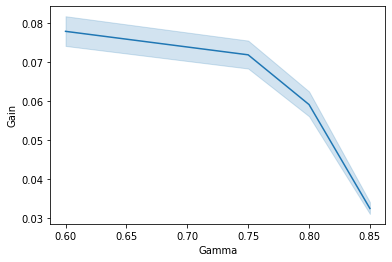

In [33]:
sns.lineplot(x='Gamma', y = 'Gain', data=df)